In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import transformers
import torch
from transformers import pipeline
import string
from transformers import BertTokenizer, BertForMaskedLM
import statistics
import keras
import re

from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

from valuemap.models import Model, MultiModel
from valuemap.values import ValueMap, ValueSearch
from sklearn.metrics.pairwise import cosine_similarity
#from gensim.models import KeyedVectors
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
# Import the human values from values.py labels
from valuemap.values import VALUE_LABELS

from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import to_categorical
from bornrule import BornClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bornrule import BornClassifier

In [15]:
def load_traintest_dataset(group):
    # Load the arguments and labels into separate DataFrames
    df_arguments = pd.read_csv('arguments-'+group+'.tsv', delimiter='\t')
    df_labels = pd.read_csv('labels-'+group+'.tsv', delimiter='\t')

    # Merge the two DataFrames on the 'Argument ID' column
    df = pd.merge(df_arguments, df_labels, on='Argument ID')

    # Extract the argument text from each DataFrame
    id = df_arguments['Argument ID'].tolist()
    arguments = df_arguments['Premise'].tolist()
    stances = df_arguments['Stance'].tolist()
    conclusions = df_arguments['Conclusion'].tolist()

    return arguments, stances, conclusions, id, df, df_labels

In [16]:
labels_training = load_traintest_dataset("training")[5]
labels_test = load_traintest_dataset("test")[5]

In [17]:
# Load training dataset
arguments_training, stances_training, conclusions_training, id_training, df_training, df_labels = load_traintest_dataset("training")

# Load test dataset
arguments_test, stances_test, conclusions_test, id_test, df_test, df_labels = load_traintest_dataset("test")

In [18]:
# Preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text

In [39]:
def important_words(classifier, vectorizer, expanded_text):
    global_weights = classifier.explain()
    
    feature_names = vectorizer.get_feature_names_out()
    
    # Dictionary with weights and feature names
    feature_weights = dict(zip(feature_names, global_weights))
    
    # Average absolute value for each matrix
    feature_weights_abs_avg = {word: np.abs(matrix).mean() for word, matrix in feature_weights.items()}
    
    # Sorted dictionary
    sorted_features = sorted(feature_weights_abs_avg.items(), key=lambda x: x[1], reverse=True)
    
    # Most important words
    for word, weight in sorted_features[:100]:
        print(f"Word: {word}, Weight: {weight}")

    added_words_weights = {}
    if len(expanded_text) != 0 :
        added_words = [text.split()[-1] for text in expanded_text]
        for word in added_words:
            if word in feature_weights_abs_avg and word not in added_words_weights:
                added_words_weights[word] = feature_weights_abs_avg[word]
        sorted_added_words = sorted(added_words_weights.items(), key=lambda x: x[1], reverse=True)

        return sorted_added_words

In [40]:
def print_and_plot_word_weights(word_weights):
    words, weights = zip(*word_weights)
    for word, weight in word_weights:
        print(f"Added word: {word}, Weight: {weight}")
    
    plt.barh(words, weights, color='skyblue')
    plt.xlabel('Importance')
    plt.title('Added Word Weights')
    plt.gca().invert_yaxis()
    plt.show()

In [41]:
classifier_original = classification("arguments-test.tsv", "arguments-training.tsv", ["Conclusion", "Stance", "Premise"])

['we should end affirmative action against affirmative action help with employment equity', 'we should end affirmative action in favor of affirmative action can be considered discriminatory against poor white', 'we should ban naturopathy in favor of naturopathy is very dangerous for the most vulnerable people like child and cancer patient people use ineffective treatment and forgo proven cure such a antibiotic or chemo often resulting in death', 'we should prohibit woman in combat in favor of woman shouldnt be in combat because they arent a strong or fast a men and can be a weak link', 'we should ban naturopathy in favor of once eradicated illness are returning due to people turning to naturopathy', 'we should end racial profiling in favor of racial profiling is a preconceived idea of people that view an entire race a criminal', 'we should end affirmative action in favor of affirmative action is not fair to the rest of the people and knowing that should not be implemented', 'we should 

In [23]:
f1_original = classifier_original[2]
precision_original = classifier_original[3]
recall_original = classifier_original[4]

In [24]:
important_words(classifier_original[0], classifier_original[1], [])

Word: zoo, Weight: 0.01260020741623353
Word: animal, Weight: 0.010339076306428078
Word: telemarketing, Weight: 0.008719924931736537
Word: language, Weight: 0.00865957829588522
Word: genderneutral, Weight: 0.008521020998747046
Word: surgery, Weight: 0.008046705935299419
Word: whaling, Weight: 0.007800343034723991
Word: cosmetic, Weight: 0.007728251679606167
Word: trading, Weight: 0.007315412263788901
Word: prayer, Weight: 0.007042545268029038
Word: algorithmic, Weight: 0.006806425883559182
Word: executive, Weight: 0.006666466665826964
Word: cannabis, Weight: 0.006357175824389416
Word: farming, Weight: 0.006204976777594849
Word: nuclear, Weight: 0.0061289258601046875
Word: factory, Weight: 0.006125049450441532
Word: compensation, Weight: 0.0060863535318488055
Word: fast, Weight: 0.005968238808303224
Word: weapon, Weight: 0.005891500614868904
Word: parade, Weight: 0.005866567214918911
Word: religion, Weight: 0.005861824577931106
Word: retirement, Weight: 0.005829298813383483
Word: austeri

In [42]:
classifier_expanded = classification("HVD-expanded_dataset_test.tsv", "HVD-expanded_dataset_training.tsv", ["EXPANDED TEXT"])

['i am against the fact that we should end affirmative action because i think that affirmative action help with employment equity i am a feminist', 'i am in favor of the fact that we should end affirmative action because i think that affirmative action can be considered discriminatory against poor white i am a conservative', 'i am in favor of the fact that we should ban naturopathy because i think that naturopathy is very dangerous for the most vulnerable people like child and cancer patient people use ineffective treatment and forgo proven cure such a antibiotic or chemo often resulting in death i am a vegetarian', 'i am in favor of the fact that we should prohibit woman in combat because i think that woman shouldnt be in combat because they arent a strong or fast a men and can be a weak link i am a feminist', 'i am in favor of the fact that we should ban naturopathy because i think that once eradicated illness are returning due to people turning to naturopathy i am a vegetarian', 'i 

In [26]:
f1_expanded = classifier_expanded[2]
precision_expanded = classifier_expanded[3]
recall_expanded = classifier_expanded[4]

In [27]:
# Get the word weights
word_weights = important_words(classifier_expanded[0], classifier_expanded[1], classifier_expanded[5])

Word: zoo, Weight: 0.010503140164865518
Word: animal, Weight: 0.008687804088393727
Word: telemarketing, Weight: 0.007321709250138616
Word: language, Weight: 0.007228904440033423
Word: genderneutral, Weight: 0.007150246903481467
Word: surgery, Weight: 0.006728677536350372
Word: whaling, Weight: 0.006433265561831512
Word: cosmetic, Weight: 0.006426472383939072
Word: trading, Weight: 0.006129982978600867
Word: prayer, Weight: 0.0060007409179791745
Word: algorithmic, Weight: 0.005725762679931968
Word: executive, Weight: 0.005610433537340092
Word: vegetarian, Weight: 0.00533274317160781
Word: nuclear, Weight: 0.005269796384063814
Word: cannabis, Weight: 0.005267796637967386
Word: farming, Weight: 0.005216614726514234
Word: factory, Weight: 0.0051235584427389725
Word: compensation, Weight: 0.005122257169018188
Word: weapon, Weight: 0.005066850570958667
Word: retirement, Weight: 0.0050418498134506265
Word: religion, Weight: 0.004960596439708389
Word: fast, Weight: 0.0049257420038125695
Word: 

Added word: vegetarian, Weight: 0.00533274317160781
Added word: christian, Weight: 0.0037244873669404835
Added word: libertarian, Weight: 0.0025435507753126937
Added word: feminist, Weight: 0.00236920631169269
Added word: conservative, Weight: 0.0017814211894955126
Added word: terrorist, Weight: 0.0016655437801078878
Added word: coward, Weight: 0.001446825874106016
Added word: turkey, Weight: 0.0013834426712676135
Added word: democrat, Weight: 0.0013307336711560263
Added word: scientist, Weight: 0.0013302784904286372
Added word: republican, Weight: 0.0012956303164335114
Added word: hacker, Weight: 0.001053231137939092
Added word: linguist, Weight: 0.0010502025620252376
Added word: muslim, Weight: 0.0010480502340549363
Added word: socialist, Weight: 0.0010146254760408507
Added word: doctor, Weight: 0.0010022990887512922
Added word: robot, Weight: 0.0009607413273409323
Added word: farmer, Weight: 0.0008350247920966064
Added word: patriot, Weight: 0.0006175356183444002
Added word: racist,

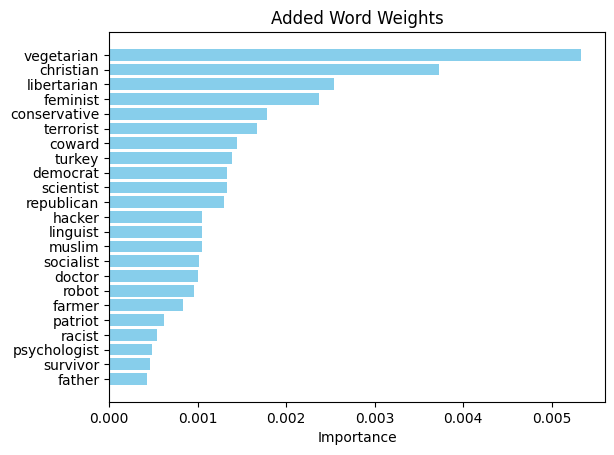

In [28]:
# Print and plot the word weights
print_and_plot_word_weights(word_weights)

In [29]:
classifier_expanded_adj = classification("HVD-expanded_dataset_test.tsv", "HVD-expanded_dataset_training.tsv", ["EXPANDED TEXT ADJECTIVES"])

F1 Score: 0.2381289783256788
Precision: 0.44416243654822335
Recall: 0.17505665337200868


In [30]:
f1_expanded_adj = classifier_expanded_adj[2]
precision_expanded_adj = classifier_expanded_adj[3]
recall_expanded_adj = classifier_expanded_adj[4]

In [31]:
word_weights_adj = important_words(classifier_expanded_adj[0], classifier_expanded_adj[1], classifier_expanded_adj[5])

Word: zoo, Weight: 0.010503140164856399
Word: animal, Weight: 0.008687804088384592
Word: telemarketing, Weight: 0.007321709250143804
Word: language, Weight: 0.007228904439939153
Word: genderneutral, Weight: 0.007150246903423868
Word: surgery, Weight: 0.006728677536348465
Word: whaling, Weight: 0.006433265561769072
Word: cosmetic, Weight: 0.006426472383936085
Word: trading, Weight: 0.006129982978602967
Word: prayer, Weight: 0.006000740917759174
Word: algorithmic, Weight: 0.005725762679932139
Word: executive, Weight: 0.00561043353733129
Word: nuclear, Weight: 0.005269796384057778
Word: cannabis, Weight: 0.005267796637978368
Word: farming, Weight: 0.0052166147265031645
Word: factory, Weight: 0.005123558442727072
Word: compensation, Weight: 0.005122257169010719
Word: weapon, Weight: 0.005066850570954179
Word: retirement, Weight: 0.0050418498134591075
Word: religion, Weight: 0.004960596439474621
Word: fast, Weight: 0.004925742003806125
Word: parade, Weight: 0.0048980584733602645
Word: auste

Added word: anarchist, Weight: 0.0021188495502459308
Added word: democrat, Weight: 0.0011766575354596027
Added word: libertarian, Weight: 0.001001847654114373
Added word: socialist, Weight: 0.0009158162066079629
Added word: capitalist, Weight: 0.0008487124399662781
Added word: centrist, Weight: 0.0005979760267660575
Added word: communist, Weight: 0.0003986523825006163
Added word: conservative, Weight: 0.0003205664063068745
Added word: liberal, Weight: 9.171759365470468e-05
Added word: republican, Weight: 8.497221189021468e-05


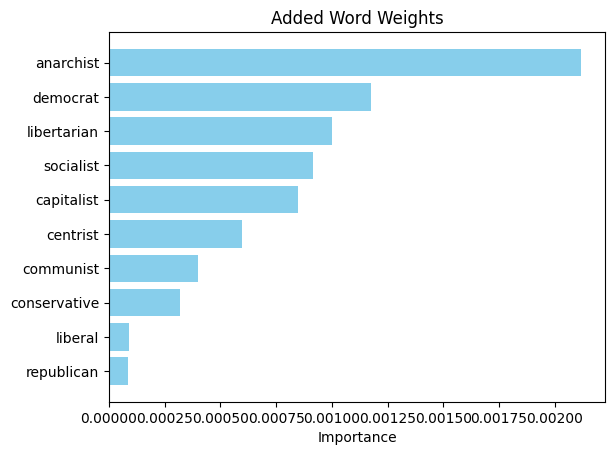

In [32]:
# Print and plot the word weights
print_and_plot_word_weights(word_weights_adj)

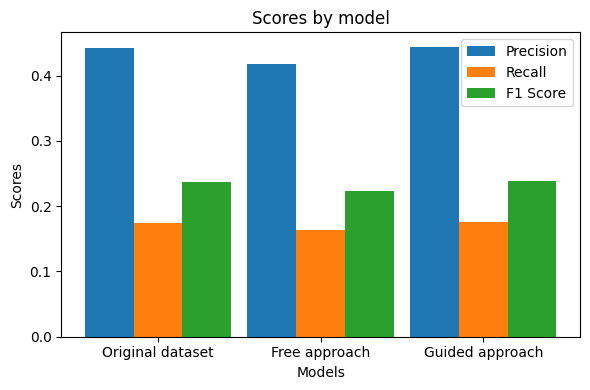

In [33]:
models = ['Original dataset', 'Free approach', 'Guided approach']
precision_vals = [precision_original, precision_expanded, precision_expanded_adj]
recall_vals = [recall_original, recall_expanded, recall_expanded_adj]
f1_vals = [f1_original, f1_expanded, f1_expanded_adj]

# Getting the x locations for the groups
x = np.arange(len(models)) 
width = 0.3

fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(x - width, precision_vals, width, label='Precision')
rects2 = ax.bar(x, recall_vals, width, label='Recall')
rects3 = ax.bar(x + width, f1_vals, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()